In [16]:
!which python 
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/main/bin/python


farshed.abdukhakimov
cn-05
/home/farshed.abdukhakimov/projects/sania


In [91]:
%load_ext autoreload
%autoreload 2

import os
import datetime
from collections import defaultdict

import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

from experiments import utils, datasets, methods
from experiments.loss_functions import LogisticRegressionLoss, BaseOracle


import scipy
# import optuna 

import svmlight_loader

from dotenv import load_dotenv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
def train_loop(dataset_name: str, dataset_scale: int, batch_size: int, n_epochs: int,
               optimizer: methods.BaseOptimizer, **optimizer_kwargs) -> dict: 
    
    np.random.seed(0)
    torch.manual_seed(0)
    
    # dataset 
    train_data, train_target, _= datasets.get_libsvm(name=dataset_name, scale=dataset_scale, seed=0)
    train_load = TensorDataset(torch.tensor(train_data), torch.tensor(train_target))
    train_dataloader = DataLoader(train_load, batch_size=batch_size, shuffle=True)
    
    test_data, test_target, _ = datasets.get_libsvm(name=dataset_name+".t", scale=dataset_scale, seed=0)
    
    # parameters
    params = np.zeros(train_data.shape[1])
    optim = optimizer(params=params, **optimizer_kwargs)

    # oracle 
    loss_function = LogisticRegressionLoss()
    
    # e.g. libsvm dataset has {0.0, 1.0} classes that cannot be used for LogisticRegressionLoss 
    # hence they will be remapped to {-1.0, 1.0}        
    if isinstance(loss_function, LogisticRegressionLoss):
        assert np.array_equal(np.unique(train_target), (-1.0, 1.0))
    
    # logging 
    history = defaultdict(list)

        
    for epoch in range(n_epochs):
        
        print(f"Epoch [{epoch}/{n_epochs}]")

        # Testing hist
        loss = loss_function.func(params, test_data, test_target)
        grad = loss_function.grad(params, test_data, test_target)
        g_norm = np.linalg.norm(grad)**2
        acc = (np.sign(test_data @ params) == test_target).sum() / test_target.shape[0]
        
        history["test/epoch/loss"].append(loss)
        history["test/epoch/acc"].append(acc)
        history["test/epoch/grad_norm"].append(g_norm)
        
        print(f"Test Loss: {loss} | Test Acc: {acc} | Test GradNorm: {g_norm}")
        
        # Training hist 
        loss = loss_function.func(params, train_data, train_target)
        grad = loss_function.grad(params, train_data, train_target)
        g_norm = np.linalg.norm(grad)**2
        acc = (np.sign(train_data @ params) == train_target).sum() / train_target.shape[0]
        
        history["train/epoch/loss"].append(loss)
        history["train/epoch/acc"].append(acc)
        history["train/epoch/grad_norm"].append(g_norm)
        
        print(f"Train Loss: {loss} | Train Acc: {acc} | Train GradNorm: {g_norm}")
        
        # Training 
        for i, (batch_data, batch_target) in enumerate(train_dataloader): 
            batch_data = batch_data.numpy()
            batch_target = batch_target.numpy()

            loss_closure = lambda params: loss_function.func(params, batch_data, batch_target)
            grad_closure = lambda params: loss_function.grad(params, batch_data, batch_target)
            
            loss, grad = optim.step(loss_closure=loss_closure, grad_closure=grad_closure)
            g_norm = np.linalg.norm(grad)**2
            acc = (np.sign(batch_data @ params) == batch_target).sum() / batch_target.shape[0]

            history["train/batch/loss"].append(loss)
            history["train/batch/acc"].append(acc)
            history["train/batch/grad_norm"].append(g_norm)
        
        
    return history

In [151]:
hist1 = train_loop("a1a", 0, 128, 500, methods.SANIA_AdamSQR, eps=0.5)

Epoch [0/500]
Test Loss: 0.6931471805599452 | Test Acc: 0.0 | Test GradNorm: 0.4549499969390798
Train Loss: 0.6931471805599452 | Train Acc: 0.0 | Train GradNorm: 0.4359846080686329
Epoch [1/500]
Test Loss: 0.3641255618979228 | Test Acc: 0.8290153766636517 | Test GradNorm: 0.008814422450947334
Train Loss: 0.3639153930418685 | Train Acc: 0.8292834890965732 | Train GradNorm: 0.010326347766071045
Epoch [2/500]
Test Loss: 0.42139860132607804 | Test Acc: 0.8063703320842486 | Test GradNorm: 0.09378428549373355
Train Loss: 0.42066124195142995 | Train Acc: 0.8068535825545171 | Train GradNorm: 0.10105798900399285
Epoch [3/500]
Test Loss: 0.34923201749142585 | Test Acc: 0.8364452771675928 | Test GradNorm: 0.009224207954157732
Train Loss: 0.3433956207198768 | Train Acc: 0.8355140186915888 | Train GradNorm: 0.01127583518685349
Epoch [4/500]
Test Loss: 0.38203540590488544 | Test Acc: 0.8216823879054141 | Test GradNorm: 0.054989579922183424
Train Loss: 0.3774314963905613 | Train Acc: 0.82305295950155

In [152]:
torch.set_default_dtype(torch.float64)
device = torch.device('cpu')

In [184]:

def rademacher_old(weights):
    return torch.round(torch.rand_like(weights)) * 2 - 1

def diag_estimate_old(weights, grad, iters):
    Ds = []
    for j in range(iters):
        z = rademacher_old(weights)
        with torch.no_grad():
            hvp = torch.autograd.grad(grad, weights, grad_outputs=z, retain_graph=True)[0]
        Ds.append((hvp*z))

    return torch.mean(torch.stack(Ds), 0)



def run_optimizer(optimizer, loss_function, train_data, train_target, train_dataloader, epochs, **kwargs_optimizer):
    # parameters
    w = torch.zeros(train_data.shape[1], device=device).requires_grad_()
    opt = optimizer([w], **kwargs_optimizer)

    # logging 
    hist = []
    
    def compute_loss(w, data, target):
        loss = loss_function(w, data, target)
        loss.backward()
        return loss


    for epoch in range(epochs):

        loss = loss_function(w, train_data.to(device), train_target.to(device))
        g, = torch.autograd.grad(loss, w, create_graph=True)
        acc = (np.sign(train_data @ w.detach().numpy()) == train_target).sum() / train_target.shape[0]
        print(f"[{epoch}/{epochs}] | Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()} | Acc: {acc}")
        hist.append([loss.item(), (torch.linalg.norm(g) ** 2).item(), acc])

        for i, (batch_data, batch_target) in enumerate(train_dataloader):
            batch_data = batch_data.to(device)
            batch_target = batch_target.to(device)
            opt.zero_grad()
            loss = compute_loss(w, batch_data, batch_target)
            opt.step()

    return hist


def run_psps2(loss_function, train_data, train_target, train_dataloader, epochs, precond_method, eps = 1.0, **kwargs):
    torch.manual_seed(0)
    np.random.seed(0)
    # parameters
    w = torch.zeros(train_data.shape[1], device=device).requires_grad_()

    # save loss and grad size to history
    hist = []
    

    loss = loss_function(w, train_data.to(device), train_target.to(device))
    g, = torch.autograd.grad(loss, w, create_graph=True)
    f_grad = g.clone().detach() 


    if precond_method == "none":
        D = torch.ones_like(w)
    elif precond_method == "hutch":
        alpha=0.1
        beta=0.999
        init_iters = kwargs["hutch_init_iters"]
        Dk = diag_estimate_old(w, g, init_iters)
    elif precond_method == "pcg":
        MAX_ITER = train_data.shape[1] * 2

    elif precond_method == "scaling_vec":
        scaling_vec = kwargs["scaling_vec"]
        D = (1 / scaling_vec)**2
    elif precond_method == "adam" or precond_method == "adam_m":
        D = torch.zeros_like(g)
        v = torch.zeros_like(g)
        step_t = torch.tensor(0.)
        betas = (0.9, 0.999)
    elif precond_method == "adagrad" or precond_method == "adagrad_m":
        D = torch.zeros_like(g)
        v = torch.zeros_like(g)

    pcg_method = kwargs.get("pcg_method")
    if pcg_method == "hutch":
        alpha=0.1
        beta=0.999
        init_iters = kwargs["hutch_init_iters"]
        Dk_pcg = diag_estimate_old(w, g, init_iters)
    elif pcg_method == "adam" or pcg_method == "adam_m":
        D_pcg = torch.zeros_like(g)
        v_pcg = torch.zeros_like(g)
        step_t_pcg = torch.tensor(0.)
        betas = (0.9, 0.999)
    elif pcg_method == "adagrad" or pcg_method == "adagrad_m":
        D_pcg = torch.zeros_like(g)
        v_pcg = torch.zeros_like(g)
    elif pcg_method == "none":
        D_pcg = torch.ones_like(g)
        
    for epoch in range(epochs):
        
        # eps = eps / 2

        loss = loss_function(w, train_data.to(device), train_target.to(device))
        g, = torch.autograd.grad(loss, w, create_graph=True)
        grad_norm_sq = torch.linalg.norm(g) ** 2  
        acc = (np.sign(train_data @ w.detach().numpy()) == train_target).sum() / train_target.shape[0]

        # print(f"[{epoch}/{epochs}] | Loss: {loss.item()} | GradNorm^2: {grad_norm_sq.item()} | Accuracy: {acc}")
        hist.append([loss.item(), grad_norm_sq.item(), acc])
           
        for i, (batch_data, batch_target) in enumerate(train_dataloader):  

            loss = loss_function(w, batch_data, batch_target)
            g, = torch.autograd.grad(loss, w, create_graph=True)
            f_grad = g.detach().clone()

            if precond_method == "scaling_vec":
                s = D * f_grad

            elif precond_method == "adam" or precond_method == "adam_m":
                step_t += 1
                v = betas[1] * v + (1 - betas[1]) * g.square()
                v_hat = v / (1 - torch.pow(betas[1], step_t))
                # sum_regularized = torch.maximum(torch.full_like(v_hat, fill_value=eps), v_hat)
                
                if precond_method == "adam":
                    s = f_grad / (torch.sqrt(v_hat) + eps)
                    # s = f_grad / torch.sqrt(sum_regularized)
                elif precond_method == "adam_m":
                    s = f_grad / (v_hat + eps) 
                    # s = f_grad / sum_regularized

            elif precond_method == "adagrad" or precond_method == "adagrad_m":
                v.add_(torch.square(g))
                sum_regularized = torch.maximum(torch.full_like(v, fill_value=eps), v)

                if precond_method == "adagrad":
                    s = f_grad / (torch.sqrt(v) + eps)
                    # s = f_grad / torch.sqrt(sum_regularized)
                elif precond_method == "adagrad_m":
                    s = f_grad / (v + eps)
                    # s = f_grad / sum_regularized

            elif precond_method == "none":
                s = D * f_grad

            elif precond_method == "hutch":
                vk = diag_estimate_old(w, g, 1)

                # Smoothing and Truncation 
                Dk = beta * Dk + (1 - beta) * vk
                Dk_hat = torch.abs(Dk)
                Dk_hat[Dk_hat < alpha] = alpha

                D = 1 / Dk_hat
                s = D * f_grad

            elif precond_method == "pcg":

                if pcg_method == "hutch":
                    vk_pcg = diag_estimate_old(w, g, 1)
                    # Smoothing and Truncation 
                    Dk_pcg = beta * Dk_pcg + (1 - beta) * vk_pcg
                    Dk_hat = torch.abs(Dk_pcg)
                    Dk_hat[Dk_hat < alpha] = alpha
                    D_pcg = 1 / Dk_hat

                elif pcg_method == "adam" or pcg_method == "adam_m":
                    step_t_pcg += 1
                    v_pcg = betas[1] * v_pcg + (1 - betas[1]) * f_grad.square()
                    v_hat = v_pcg / (1 - torch.pow(betas[1], step_t_pcg))
                    if pcg_method == "adam":
                        D_pcg = 1 / (torch.sqrt(v_hat) + 1e-6)
                    else:
                        D_pcg = 1 / (v_hat + 1e-6)

                elif pcg_method == "adagrad" or pcg_method == "adagrad_m":
                    v_pcg.add_(f_grad.square())
                    if pcg_method == "adagrad":
                        D_pcg = 1 / (torch.sqrt(v_pcg) + 1e-6)
                    else:
                        D_pcg = 1 / (v_pcg + 1e-6)

                hess_diag_inv = D_pcg.clone()
                # Preconditioned CG is here
                s = torch.zeros_like(w) # s = H_inv * grad
                r = f_grad.clone()
                z = hess_diag_inv * r
                p = z.detach().clone()

                for cg_step in range(MAX_ITER):
                    hvp = torch.autograd.grad(g, w, grad_outputs=p, retain_graph=True)[0]
                    alpha_k = torch.dot(r, z) / torch.dot(p, hvp)
                    s = s + alpha_k * p
                    r_prev = r.clone()
                    r = r - alpha_k * hvp
                    if torch.norm(r) < 1e-4:
                        break
                    
                    z_prev = z.clone()
                    z = hess_diag_inv * r
                    beta_k = torch.dot(r, z) / torch.dot(r_prev, z_prev)
                    p = z + beta_k * p    


            grad_norm_sq_scaled = torch.dot(f_grad, s)

            if 2 * loss <= grad_norm_sq_scaled:
                det = 1 - ( (2 * loss) / ( grad_norm_sq_scaled )) 
                step_size = 1 - torch.sqrt(det)
            else:
                # print(f"[{epoch}, {i}] No solution")
                step_size = 1.0

                
            with torch.no_grad():
                w.sub_(step_size * s)

    return hist

In [185]:
def logreg(w, X, y):
    return torch.mean(torch.log(1 + torch.exp(-y * (X @ w))))


torch.manual_seed(0)
np.random.seed(0)

dataset_name = "a1a"
dataset_scale = 0
batch_size = 128
train_data, train_target, _= datasets.get_libsvm(name=dataset_name, scale=dataset_scale, seed=0)
train_data = torch.tensor(train_data)
train_target = torch.tensor(train_target)
train_load = TensorDataset(train_data, train_target)
train_dataloader = DataLoader(train_load, batch_size=batch_size, shuffle=True)

    
hist2 = run_psps2(logreg, train_data, train_target, train_dataloader, 500, "adam_m", eps=1.5)

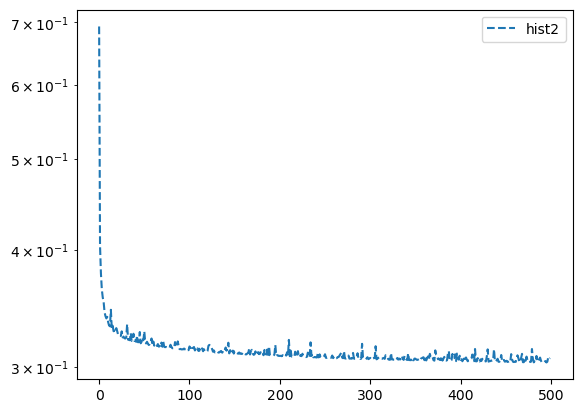

In [186]:
# plt.semilogy(hist1["train/epoch/loss"], label="hist1")
plt.semilogy([x[0] for x in hist2], linestyle="--", label="hist2")

plt.legend()

In [143]:
hist_adam1 = train_loop("a1a", 0, 128, 500, methods.Adagrad, lr=0.1)

Epoch [0/500]
Test Loss: 0.6931471805599452 | Test Acc: 0.0 | Test GradNorm: 0.4549499969390798
Train Loss: 0.6931471805599452 | Train Acc: 0.0 | Train GradNorm: 0.4359846080686329
Epoch [1/500]
Test Loss: 0.374287320795298 | Test Acc: 0.8308243959167851 | Test GradNorm: 0.0037326950634616477
Train Loss: 0.37381653815358595 | Train Acc: 0.8348909657320872 | Train GradNorm: 0.003425338727719227
Epoch [2/500]
Test Loss: 0.35507825138842286 | Test Acc: 0.8357668949476676 | Test GradNorm: 0.0016275815273661407
Train Loss: 0.35070453210077085 | Train Acc: 0.8392523364485981 | Train GradNorm: 0.0020823008599086057
Epoch [3/500]
Test Loss: 0.3494059299596812 | Test Acc: 0.8421307662488694 | Test GradNorm: 0.003522924046600861
Train Loss: 0.34138845810991203 | Train Acc: 0.8367601246105919 | Train GradNorm: 0.0023203858215436342
Epoch [4/500]
Test Loss: 0.34423514138357064 | Test Acc: 0.841678511435586 | Test GradNorm: 0.0006240834624278102
Train Loss: 0.33459644426859597 | Train Acc: 0.839875

In [144]:
from torch import optim

hist_adam2 = run_optimizer(optim.Adagrad, logreg, train_data, train_target, train_dataloader, 500, lr=0.1)

[0/500] | Loss: 0.6931471805599453 | GradNorm^2: 0.7733304714186172 | Acc: 0.0
[1/500] | Loss: 0.37490747865397916 | GradNorm^2: 0.008910386048902331 | Acc: 0.8305295950155763
[2/500] | Loss: 0.35156821459985155 | GradNorm^2: 0.0022040508504374535 | Acc: 0.8336448598130841
[3/500] | Loss: 0.34281508058522037 | GradNorm^2: 0.004263236895754371 | Acc: 0.8404984423676013
[4/500] | Loss: 0.33693905897615106 | GradNorm^2: 0.0029019813152215915 | Acc: 0.8398753894080997
[5/500] | Loss: 0.3324356074529611 | GradNorm^2: 0.0007497290021224474 | Acc: 0.838006230529595
[6/500] | Loss: 0.33190301039256404 | GradNorm^2: 0.007819601368112536 | Acc: 0.8467289719626169
[7/500] | Loss: 0.32727628996909364 | GradNorm^2: 0.00020648164698832552 | Acc: 0.8411214953271028
[8/500] | Loss: 0.32617344829330525 | GradNorm^2: 0.0028519302173063937 | Acc: 0.8448598130841122
[9/500] | Loss: 0.32419537112382335 | GradNorm^2: 0.0011891597406113452 | Acc: 0.8454828660436137
[10/500] | Loss: 0.3226607888248423 | GradN

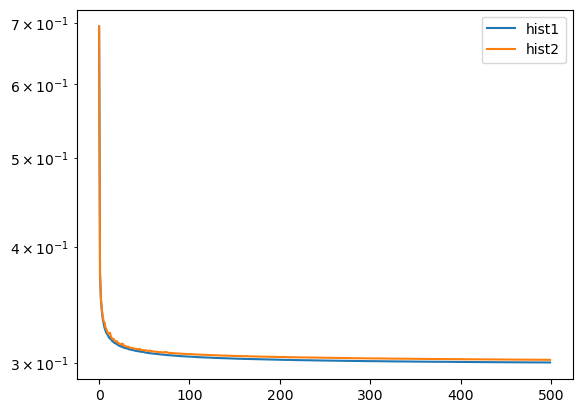

In [145]:
plt.semilogy(hist_adam1["train/epoch/loss"], label="hist1")
plt.semilogy([x[0] for x in hist_adam2], label="hist2")

plt.legend()